In [1]:
from mido import MidiFile
from music21 import converter, midi
import pretty_midi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Load the MIDI file
mid = MidiFile('Twinkle2.mid')

# Print basic information about the MIDI file
print(f"Number of tracks: {len(mid.tracks)}")
print(f"Ticks per beat: {mid.ticks_per_beat}")

# Inspect the first track's messages
for i, track in enumerate(mid.tracks):
    print(f"Track {i}: {track.name}")
    for msg in track[:10]:  # Print the first 10 messages
        print(msg)


midi_path = 'Twinkle.mid'
midi_path2 = 'Twinkle2.mid'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Number of tracks: 2
Ticks per beat: 256
Track 0: Greensleeves
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('key_signature', key='C', time=0)
MetaMessage('set_tempo', tempo=631577, time=0)
MetaMessage('track_name', name='Greensleeves', time=0)
MetaMessage('text', text='Traditional', time=0)
MetaMessage('copyright', text='Jim Paterson', time=0)
MetaMessage('end_of_track', time=1)
Track 1: Piano
program_change chan

In [1]:
def show_sheet(midi_path):
    import os
    # Path to your MuseScore executable
    musescore_path = "/Applications/MuseScore 4.app/Contents/MacOS/mscore"  # Update this with your actual path

    # Path where you want to save the resulting music sheet
    output_music_sheet = midi_path.rsplit('.', 1)[0] + ".musicxml"  # Or use '.musicxml' for xml output

    # Command to run MuseScore from the command line for converting MIDI to MusicXML or PDF
    os.system(f'"{musescore_path}" "{midi_path}" -o "{output_music_sheet}"')
    
    import music21
    score = music21.converter.parse(output_music_sheet)

    # Show the music score in a default viewer (e.g., MuseScore or web-based viewer)
    score.show()

In [1]:
import pretty_midi
import matplotlib.pyplot as plt

def midi_visualize(midi_path, time_per_row=10):
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    # Calculate the number of rows based on total time and time per row
    total_time = max(note.end for instrument in midi_data.instruments for note in instrument.notes)
    num_rows = int(total_time // time_per_row) + 1  # Calculate number of rows needed

    # Create a figure to visualize the MIDI note events with velocity as color
    plt.figure(figsize=(14, num_rows * 5))  # Increase height to provide more vertical spacing
    
    # Plot the notes with horizontal bars and display their pitch, time, and velocity details
    for row in range(num_rows):
        plt.subplot(num_rows, 1, row + 1)  # Create a subplot for each row
        
        # Plot notes within the current time range
        start_time = row * time_per_row
        end_time = (row + 1) * time_per_row
        
        # Visualize notes
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                if start_time <= note.start < end_time:
                    # Normalize the velocity for color mapping (0-127 velocity to a 0-1 range)
                    velocity_norm = note.velocity / 127
                    # Plot the bar with a color based on velocity
                    plt.barh(note.pitch, note.end - note.start, left=note.start, height=1, color=plt.cm.viridis(velocity_norm))  # Increase height to add vertical space
                    # Add pitch and time above the bar, velocity below the bar with better spacing
                    plt.text(note.start + 0.1, note.pitch + 1, f'P{note.pitch}\nT{note.start:.2f}', va='bottom', fontsize=8, ha='left')
                    plt.text(note.start + 0.1, note.pitch - 1, f'V{note.velocity}', va='top', fontsize=8, ha='left')

        # Visualize pedal events (control change number 64, sustain pedal)
        pedal_start_time = None
        pedal_strength = None
        
        for control in midi_data.instruments[0].control_changes:
            if control.number == 64:  # Sustain pedal
                if control.value > 0 and pedal_start_time is None:  # Pedal pressed
                    pedal_start_time = control.time
                    pedal_strength = control.value
                elif control.value == 0 and pedal_start_time is not None:  # Pedal released
                    pedal_end_time = control.time
                    pedal_duration = pedal_end_time - pedal_start_time
                    
                    # Add a visual representation for pedal usage
                    if start_time <= pedal_start_time < end_time:
                        plt.axvspan(pedal_start_time, pedal_end_time, color='orange', alpha=0.3, label='Pedal')
                        plt.text(pedal_start_time + 0.1, max(note.pitch for instrument in midi_data.instruments for note in instrument.notes) + 3, 
                                 f'Pedal\nStrength: {pedal_strength}\nDuration: {pedal_duration:.2f}s', 
                                 va='bottom', fontsize=8, ha='left', color='red')
                    pedal_start_time = None  # Reset for the next pedal event

        # Add labels only to the last subplot
        if row == num_rows - 1:
            plt.xlabel('Time (seconds)')
        plt.ylabel('Pitch')
        plt.xlim(start_time, end_time)  # Set the correct time range for each row

        # Adjust y-limits to provide more space between notes
        plt.ylim(min([note.pitch for instrument in midi_data.instruments for note in instrument.notes]) - 5,
                 max([note.pitch for instrument in midi_data.instruments for note in instrument.notes]) + 5)  # Increase padding to add more vertical space
    
    plt.suptitle('MIDI Note Visualization with Pedal Usage', y=1.02)  # Adjust the overall title position
    plt.tight_layout()
    
    # Add a color bar to represent the velocity mapping
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(0, 127))
    sm.set_array([])
    plt.colorbar(sm, label='Velocity', ax=plt.gcf().axes, orientation='horizontal', pad=0.03)

    # Show the plot
    plt.show()

# Example usage:
# midi_visualize('path_to_your_midi_file.mid', time_per_row=10)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [15]:
import pretty_midi
from music21 import converter
import pandas as pd

def midi_df(midi_path):
    # 說明及單位的輸出
    def print_description():
        print("說明及單位：\n")
        print("1. Pitch (音高)：顯示為 MIDI 數字和音符名稱，範圍通常為 0 到 127。")
        print("2. Velocity (力度)：範圍從 0 到 127，表示音符按下的強度，通常越大表示越強。")
        print("3. Duration (持續時間)：以四分音符為單位，表示音符持續的時長。")
        print("4. Onset Time (開始時間)：以四分音符為單位，表示音符在什麼時候開始演奏。")
        print("5. Legato/Staccato：是否連續，Legato 表示音符之間連續，Staccato 表示音符之間分離。")
        print("6. Pedal Usage (踏板使用)：延音踏板的使用狀況。")
        print("7. Tempo (速度)：曲目的速度，單位為 microseconds per beat。\n")
    
    # Load the MIDI file and convert it to a music21 score object
    score = converter.parse(midi_path)
    
    # Prepare a dictionary to store notes based on their onset time
    note_data = {}
    
    # Function to assign left and right hand based on pitch
    def assign_hand(pitch_midi):
        if pitch_midi >= 60:  # C4 is MIDI 60
            return "Right Hand"
        else:
            return "Left Hand"
    
    # 初始化前一個音符的結束時間
    previous_note_end = None
    
    # Iterate through each note and collect the relevant features
    for note in score.flat.notes:
        onset_time = note.offset  # Use the onset time as the key
        if onset_time not in note_data:
            note_data[onset_time] = {
                "Pitch (MIDI number)": [],
                "Pitch (Name)": [],
                "Velocity (0-127)": [],
                "Duration (quarter notes)": note.quarterLength,
                "Onset Time (quarter notes)": onset_time,
                "Legato/Staccato": [],
                "Hand": [],
                "Pedal Usage": "No",
                "Pedal Strength (0-127)": "N/A",
                "Pedal Duration (seconds)": "N/A",
                "Tempo": score.metronomeMarkBoundaries()[0][2].number if score.metronomeMarkBoundaries() else "Unknown"
            }
        
        if note.isNote:  # 如果是單音符
            note_data[onset_time]["Pitch (MIDI number)"].append(str(note.pitch.midi))
            note_data[onset_time]["Pitch (Name)"].append(note.pitch.nameWithOctave)
            note_data[onset_time]["Hand"].append(assign_hand(note.pitch.midi))
        elif note.isChord:  # 如果是和弦
            for p in note.pitches:
                note_data[onset_time]["Pitch (MIDI number)"].append(str(p.midi))
                note_data[onset_time]["Pitch (Name)"].append(p.nameWithOctave)
                note_data[onset_time]["Hand"].append(assign_hand(p.midi))
        
        # 添加力度和斷奏/連奏信息
        note_data[onset_time]["Velocity (0-127)"].append(str(note.volume.velocity))
        
        # 比較當前音符的開始時間與前一個音符的結束時間來判斷斷奏/連奏
        if previous_note_end is not None:
            if onset_time - previous_note_end < 0.03:  # 判斷是否連奏 (例如小於0.1秒)
                note_data[onset_time]["Legato/Staccato"].append("Legato")
            else:
                note_data[onset_time]["Legato/Staccato"].append("Staccato")
        else:
            note_data[onset_time]["Legato/Staccato"].append("Staccato")  # 第一個音符假設為Staccato
        
        # 更新前一個音符的結束時間
        previous_note_end = onset_time + note.quarterLength

    # 使用 pretty_midi 來提取延音踏板使用
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    for instrument in midi_data.instruments:
        for control in instrument.control_changes:
            if control.number == 64 and control.value > 0:  # 64 表示延音踏板
                onset_time = control.time  # 將踏板時間與音符的開始時間對應
                if onset_time in note_data:
                    note_data[onset_time]["Pedal Usage"] = "Yes"
                    note_data[onset_time]["Pedal Strength (0-127)"] = control.value
                # 當延音踏板釋放時，計算持續時間
                elif control.value == 0 and onset_time in note_data:
                    previous_time = next(time for time in note_data if note_data[time]["Pedal Usage"] == "Yes")
                    pedal_duration = onset_time - previous_time
                    note_data[previous_time]["Pedal Duration (seconds)"] = pedal_duration
    
    # Convert the dictionary into a pandas DataFrame
    note_df = pd.DataFrame.from_dict(note_data, orient='index')
    
    # Join list values into strings for better display
    note_df["Pitch (MIDI number)"] = note_df["Pitch (MIDI number)"].apply(lambda x: ', '.join(x))
    note_df["Pitch (Name)"] = note_df["Pitch (Name)"].apply(lambda x: ', '.join(x))
    note_df["Velocity (0-127)"] = note_df["Velocity (0-127)"].apply(lambda x: ', '.join(x))
    note_df["Legato/Staccato"] = note_df["Legato/Staccato"].apply(lambda x: ', '.join(x))
    note_df["Hand"] = note_df["Hand"].apply(lambda x: ', '.join(x))
    
    # Apply different text color for single notes and chords
    def color_single_chord(val):
        if ',' in val:  # Chord has multiple notes
            return 'color: green'
        else:
            return 'color: blue'
    
    # Print the description
    print_description()
    
    # Display the pandas DataFrame with styled colors
    from IPython.display import display
    styled_df = note_df.style.applymap(color_single_chord, subset=['Pitch (MIDI number)', 'Pitch (Name)'])
    display(styled_df)



In [16]:
import pretty_midi
from pydub import AudioSegment
from pydub.playback import play
import numpy as np
import tempfile
import os

def midi_to_audio(midi_path):
    # 讀取 MIDI 文件
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    # 使用預設的鋼琴合成器來生成音頻
    audio_data = midi_data.fluidsynth()  # 這會生成音頻數據
    
    # 設定採樣率
    sample_rate = 44100
    
    # 將音頻數據轉換為16位的PCM格式，這是大多數音頻文件使用的格式
    audio_data = np.int16(audio_data / np.max(np.abs(audio_data)) * 32767)
    
    # 創建臨時音頻文件
    temp_wav = tempfile.NamedTemporaryFile(delete=False, suffix=".wav")
    
    # 保存為 WAV 文件
    pretty_midi.utilities.save_wavefile(temp_wav.name, audio_data, sample_rate)
    
    # 使用 pydub 加載並播放音頻
    sound = AudioSegment.from_wav(temp_wav.name)
    play(sound)
    
    # 刪除臨時文件
    os.remove(temp_wav.name)

# Example usage:
# midi_to_audio("path_to_your_midi_file.mid")


In [17]:
# 完整的 MIDI 控制變更編號對應的功能名稱（中文翻譯）
control_change_dict = {
    0: "音色庫選擇",
    1: "調制輪",
    2: "呼吸控制",
    4: "腳踏控制",
    5: "端口滑音時間",
    6: "數據條值",
    7: "音量",
    8: "平衡",
    10: "聲像",
    11: "表情控制",
    12: "效果控制1",
    13: "效果控制2",
    16: "通道控制器1",
    17: "通道控制器2",
    18: "通道控制器3",
    19: "通道控制器4",
    64: "延音踏板 (持續)",
    65: "端口滑音開關",
    66: "持音踏板",
    67: "弱音踏板",
    68: "腳踏控制",
    69: "持續聲音2",
    70: "音色選擇變化",
    71: "共鳴控制",
    72: "聲音鬆開時間",
    73: "聲音攻擊時間",
    74: "聲音亮度",
    75: "音色控制6",
    76: "音色控制7",
    77: "音色控制8",
    78: "音色控制9",
    79: "音色控制10",
    80: "效果深度1",
    81: "效果深度2",
    82: "效果深度3",
    83: "效果深度4",
    84: "效果深度5",
    85: "數據條增量",
    86: "數據條減量",
    91: "混響效果級別",
    92: "疊音效果級別",
    93: "合唱效果級別",
    94: "顫音效果級別",
    95: "延遲效果級別",
    96: "RPN 增量",
    97: "RPN 減量",
    98: "NRPN (非註冊參數) LSB",
    99: "NRPN (非註冊參數) MSB",
    100: "RPN (註冊參數) LSB",
    101: "RPN (註冊參數) MSB",
    120: "所有音關閉",
    121: "重置控制器",
    122: "本地控制開關",
    123: "所有音符關閉",
    124: "全通道音符關閉",
    125: "全通道聲音關閉",
    126: "全通道聲音停止",
    127: "所有控制器重置"
}


In [2]:


def check_control_changes(midi_path):
    # 讀取 MIDI 文件
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    
    # 檢查控制變更消息
    for instrument in midi_data.instruments:
        for control in instrument.control_changes:
            # 根據控制編號從字典中獲取中文名稱
            control_name = control_change_dict.get(control.number, f"未知控制變更 ({control.number})")
            print(f"控制變更: {control_name}, 值: {control.value}, 時間: {control.time}")
            
            # 檢查是否為延音踏板的控制變更
            if control.number == 64:  # 64 表示延音踏板
                if control.value == 0:
                    print(f"延音踏板釋放: 值 = {control.value}, 時間 = {control.time}")
                else:
                    print(f"延音踏板按下: 值 = {control.value}, 時間 = {control.time}")



In [19]:
def midi_analysis(midi_path):
    #midi_to_audio(midi_path)
    check_control_changes(midi_path)
    show_sheet(midi_path)
    midi_visualize(midi_path, time_per_row=15)
    midi_df(midi_path)
    



控制變更: 重置控制器, 值: 0, 時間: 0.0
控制變更: 音量, 值: 100, 時間: 0.0
控制變更: 聲像, 值: 64, 時間: 0.0
控制變更: 混響效果級別, 值: 0, 時間: 0.0
控制變更: 合唱效果級別, 值: 0, 時間: 0.0


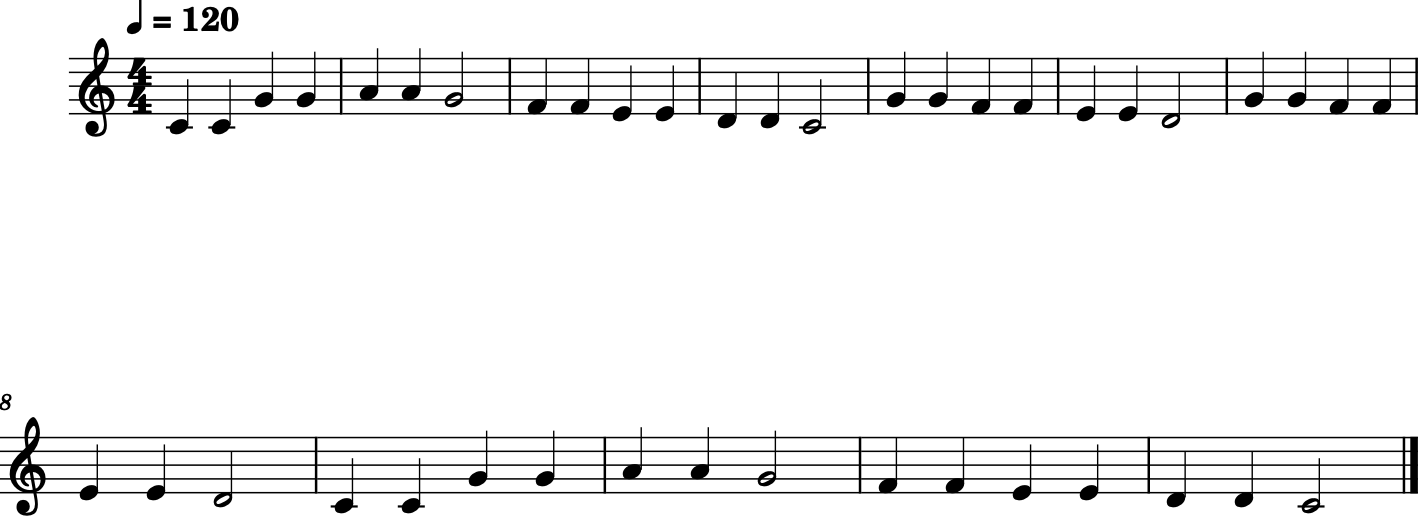

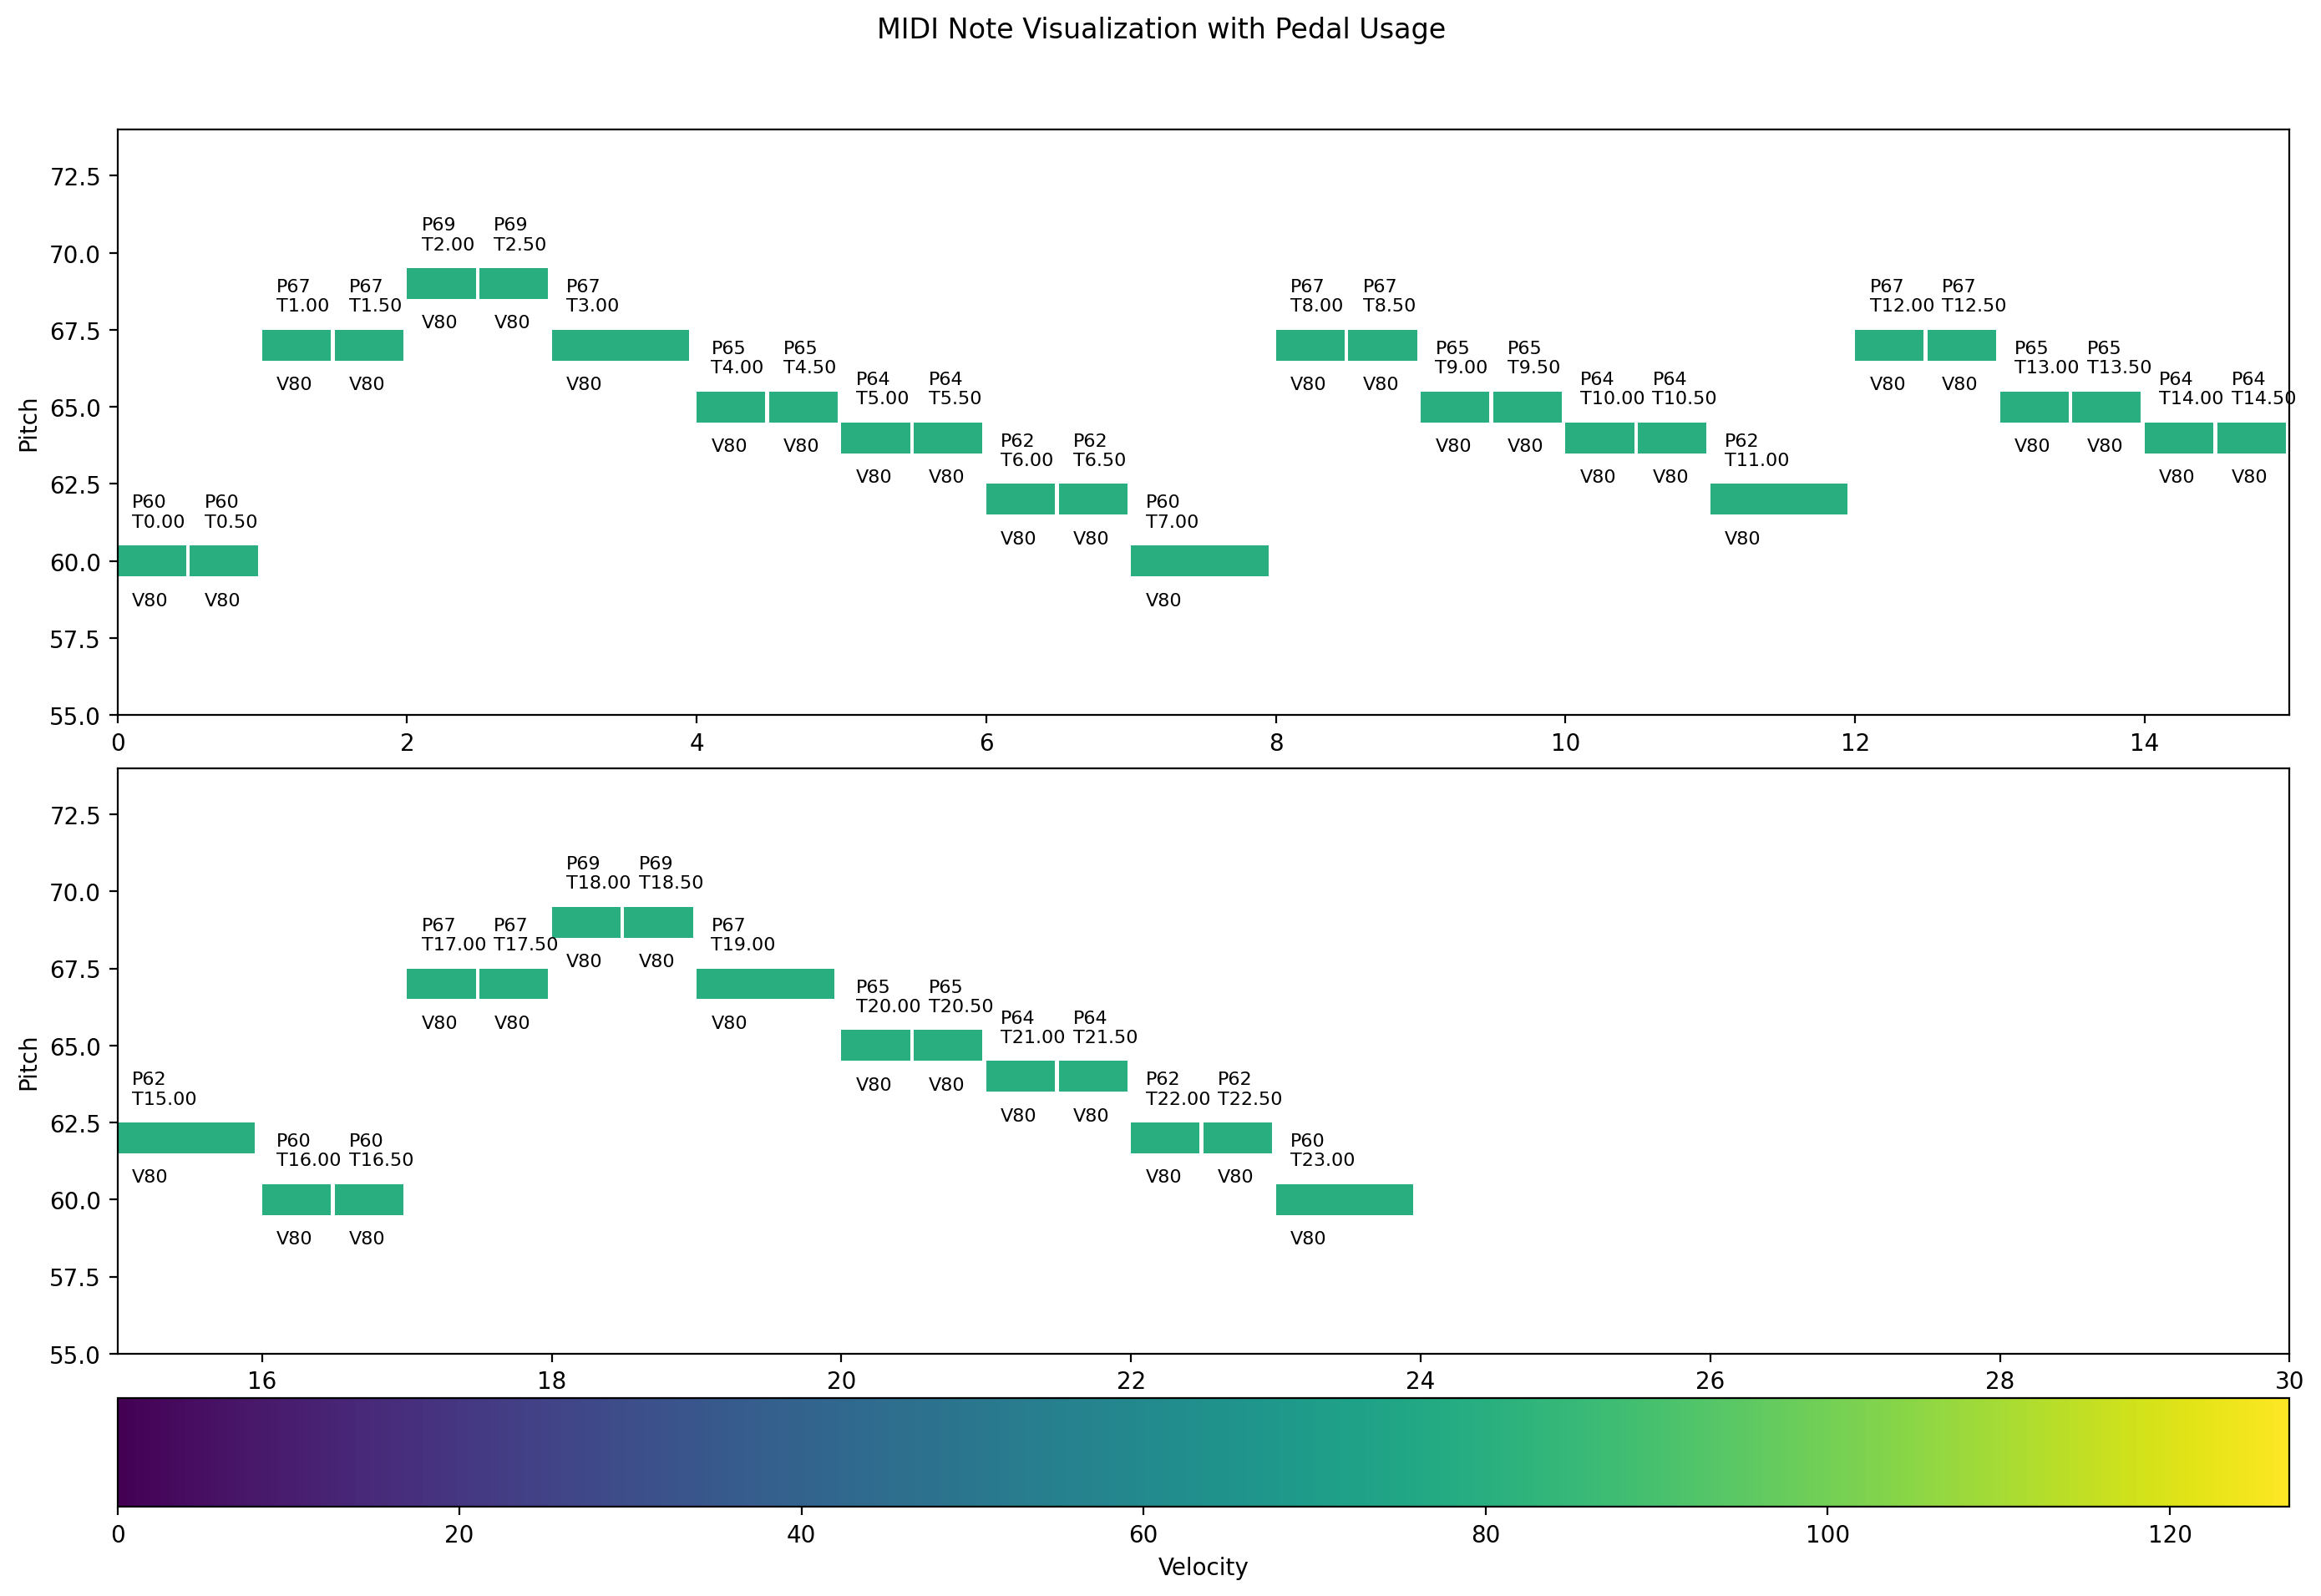

說明及單位：

1. Pitch (音高)：顯示為 MIDI 數字和音符名稱，範圍通常為 0 到 127。
2. Velocity (力度)：範圍從 0 到 127，表示音符按下的強度，通常越大表示越強。
3. Duration (持續時間)：以四分音符為單位，表示音符持續的時長。
4. Onset Time (開始時間)：以四分音符為單位，表示音符在什麼時候開始演奏。
5. Legato/Staccato：是否連續，Legato 表示音符之間連續，Staccato 表示音符之間分離。
6. Pedal Usage (踏板使用)：延音踏板的使用狀況。
7. Tempo (速度)：曲目的速度，單位為 microseconds per beat。



In [20]:
midi_analysis("Twinkle.mid")

控制變更: 重置控制器, 值: 0, 時間: 0.0
控制變更: 延音踏板 (持續), 值: 0, 時間: 0.0
延音踏板釋放: 值 = 0, 時間 = 0.0
控制變更: 聲像, 值: 63, 時間: 0.0
控制變更: 音量, 值: 95, 時間: 0.0
控制變更: 重置控制器, 值: 0, 時間: 0.0
控制變更: 延音踏板 (持續), 值: 0, 時間: 0.0
延音踏板釋放: 值 = 0, 時間 = 0.0
控制變更: 聲像, 值: 63, 時間: 0.0
控制變更: 音量, 值: 95, 時間: 0.0


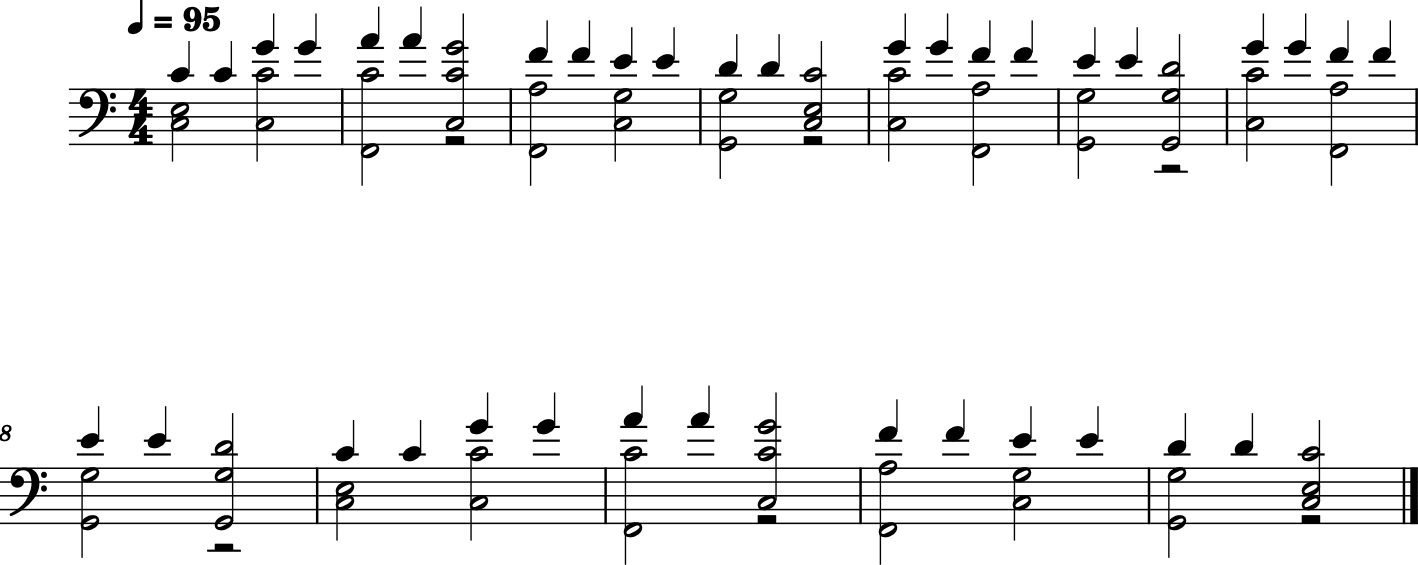

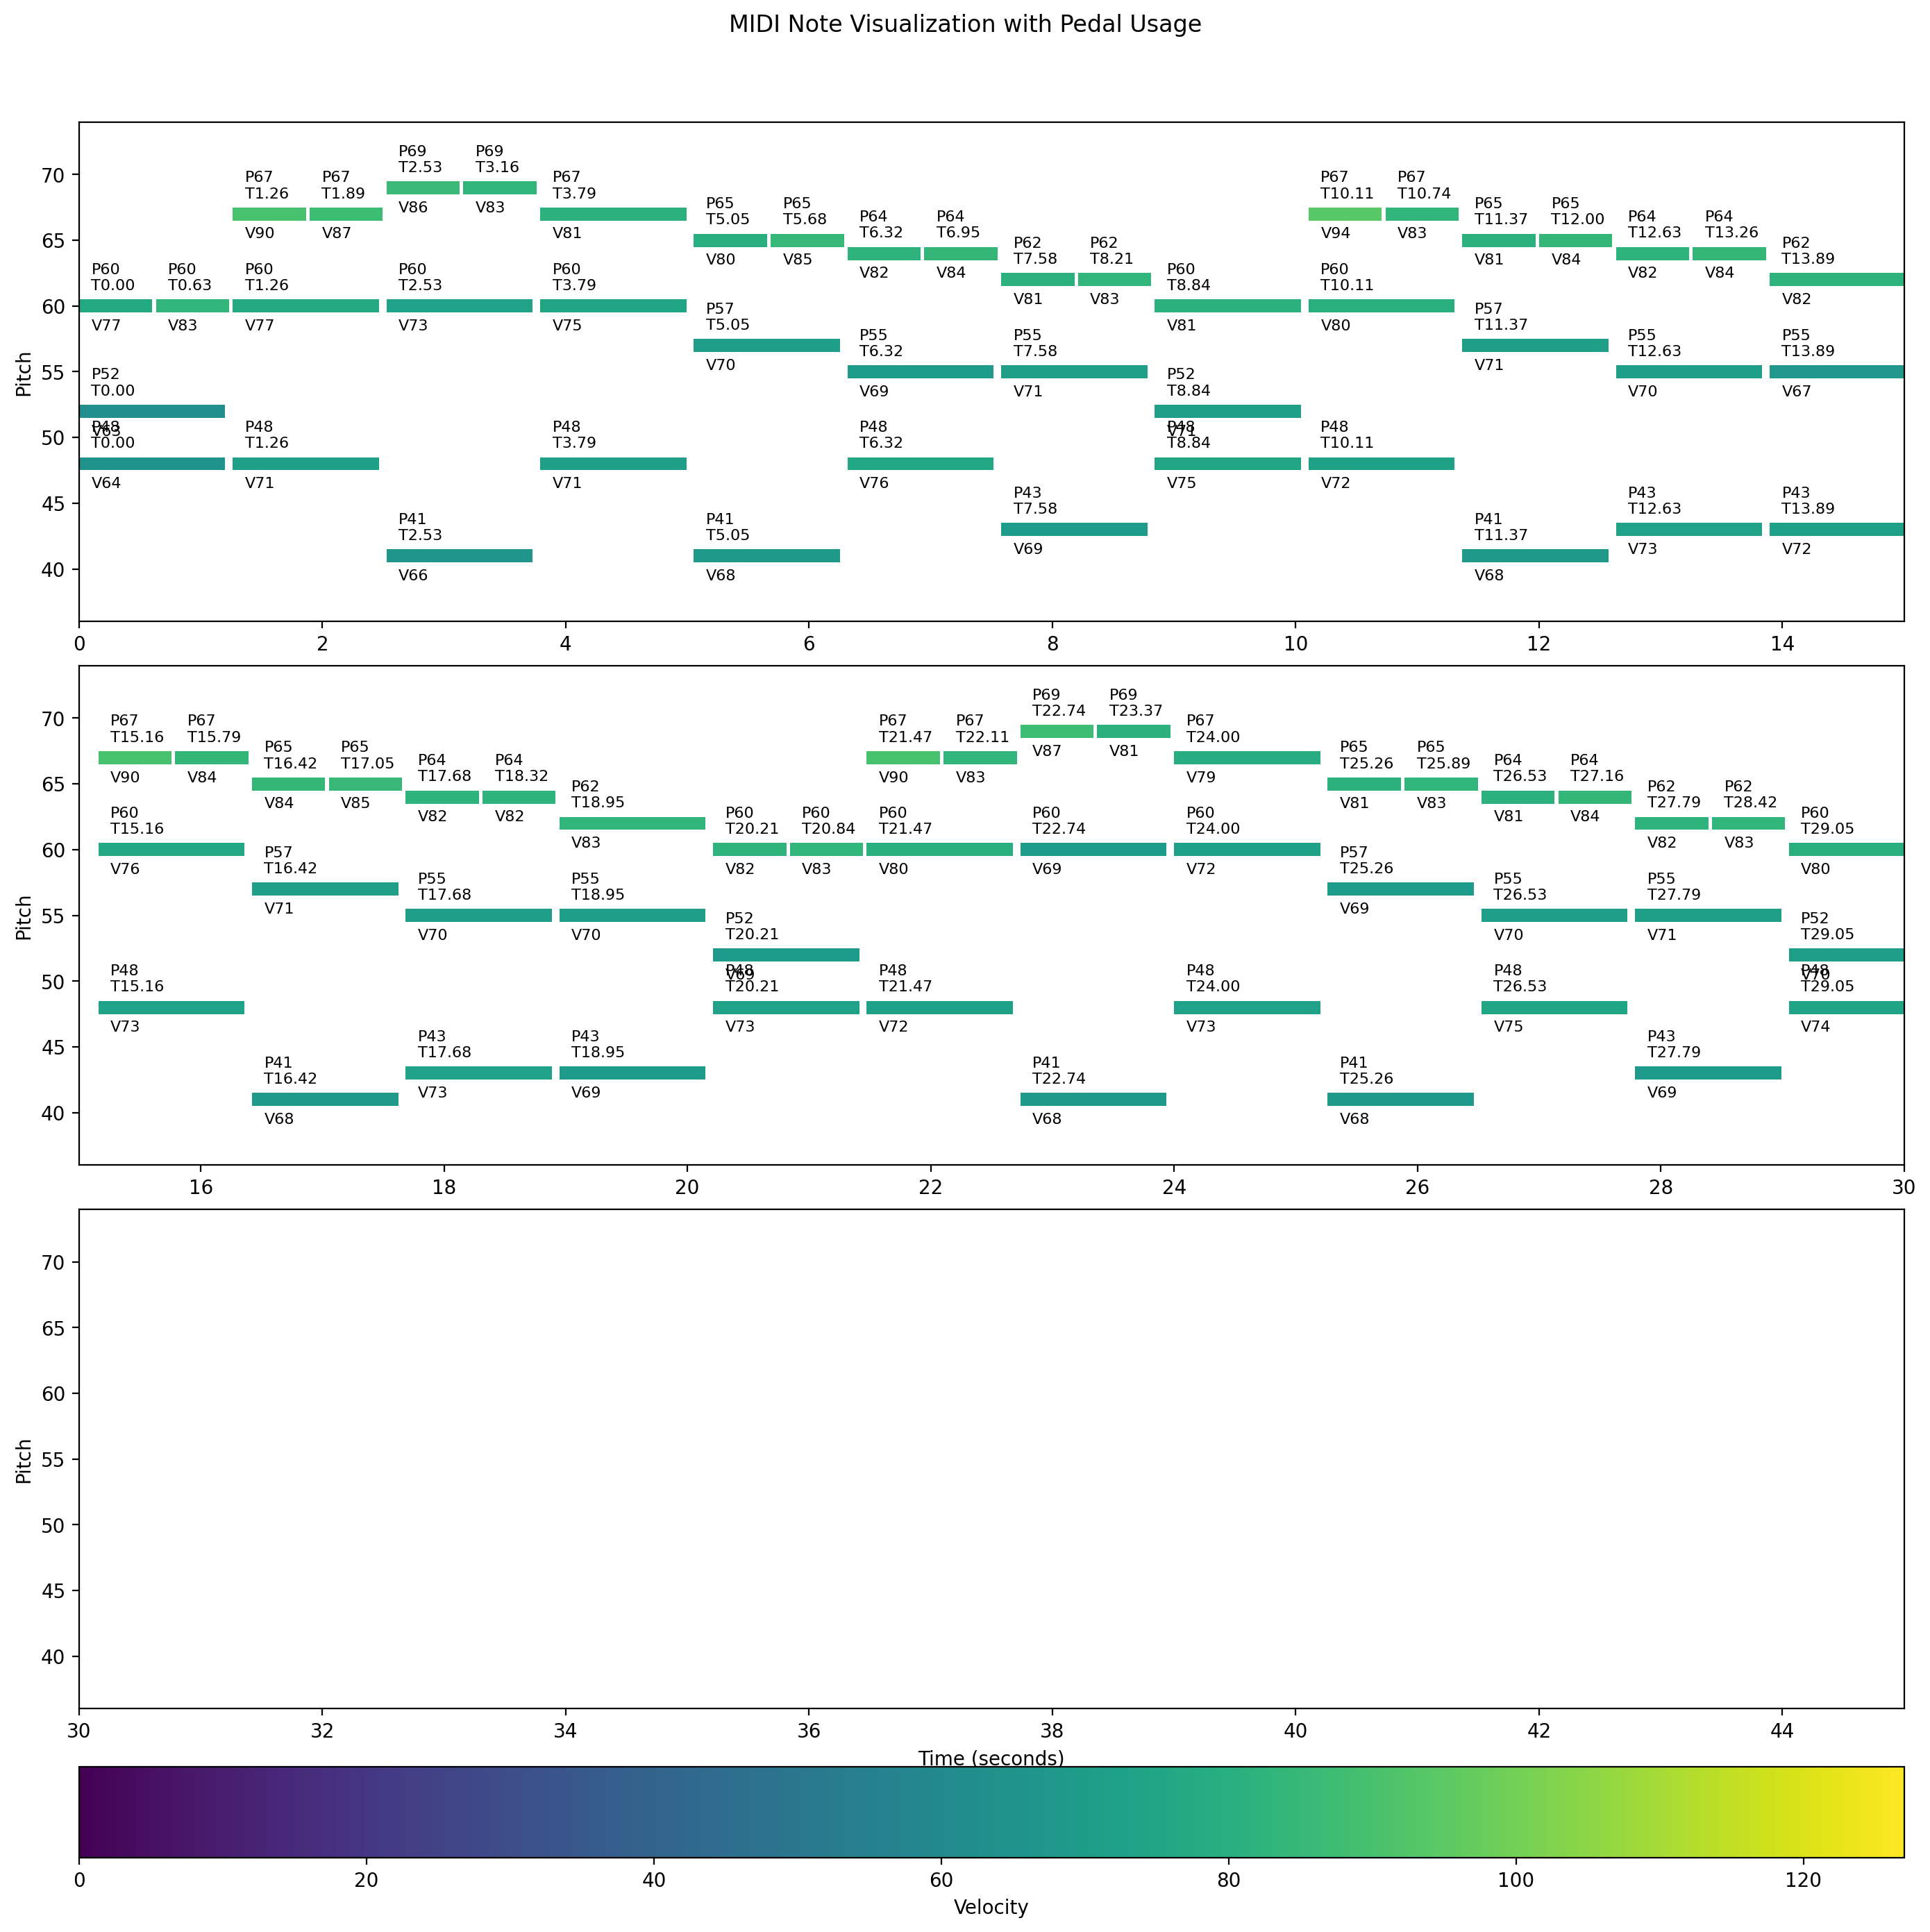

說明及單位：

1. Pitch (音高)：顯示為 MIDI 數字和音符名稱，範圍通常為 0 到 127。
2. Velocity (力度)：範圍從 0 到 127，表示音符按下的強度，通常越大表示越強。
3. Duration (持續時間)：以四分音符為單位，表示音符持續的時長。
4. Onset Time (開始時間)：以四分音符為單位，表示音符在什麼時候開始演奏。
5. Legato/Staccato：是否連續，Legato 表示音符之間連續，Staccato 表示音符之間分離。
6. Pedal Usage (踏板使用)：延音踏板的使用狀況。
7. Tempo (速度)：曲目的速度，單位為 microseconds per beat。



In [21]:
midi_analysis("Twinkle2.mid")

控制變更: 音量, 值: 100, 時間: 0.0
控制變更: 聲像, 值: 64, 時間: 0.0
控制變更: 混響效果級別, 值: 127, 時間: 0.0
控制變更: 音量, 值: 100, 時間: 0.0
控制變更: 聲像, 值: 64, 時間: 0.0
控制變更: 延音踏板 (持續), 值: 127, 時間: 0.0
延音踏板按下: 值 = 127, 時間 = 0.0
控制變更: 混響效果級別, 值: 127, 時間: 0.0
控制變更: 混響效果級別, 值: 127, 時間: 3.2311085000000004
控制變更: 混響效果級別, 值: 127, 時間: 3.2311085000000004
控制變更: 延音踏板 (持續), 值: 0, 時間: 3.248000395833334
延音踏板釋放: 值 = 0, 時間 = 3.248000395833334
控制變更: 延音踏板 (持續), 值: 127, 時間: 3.410162595833334
延音踏板按下: 值 = 127, 時間 = 3.410162595833334
控制變更: 混響效果級別, 值: 127, 時間: 6.394017
控制變更: 混響效果級別, 值: 127, 時間: 6.394017
控制變更: 延音踏板 (持續), 值: 0, 時間: 6.4091176687499996
延音踏板釋放: 值 = 0, 時間 = 6.4091176687499996
控制變更: 延音踏板 (持續), 值: 127, 時間: 6.536634427083333
延音踏板按下: 值 = 127, 時間 = 6.536634427083333
控制變更: 混響效果級別, 值: 127, 時間: 9.560101249999997
控制變更: 混響效果級別, 值: 127, 時間: 9.560101249999997
控制變更: 延音踏板 (持續), 值: 0, 時間: 9.574903887499998
延音踏板釋放: 值 = 0, 時間 = 9.574903887499998
控制變更: 延音踏板 (持續), 值: 127, 時間: 9.722930262499997
延音踏板按下: 值 = 127, 時間 = 9.722930262499997
控制變更: 混響效果級別, 值: 12

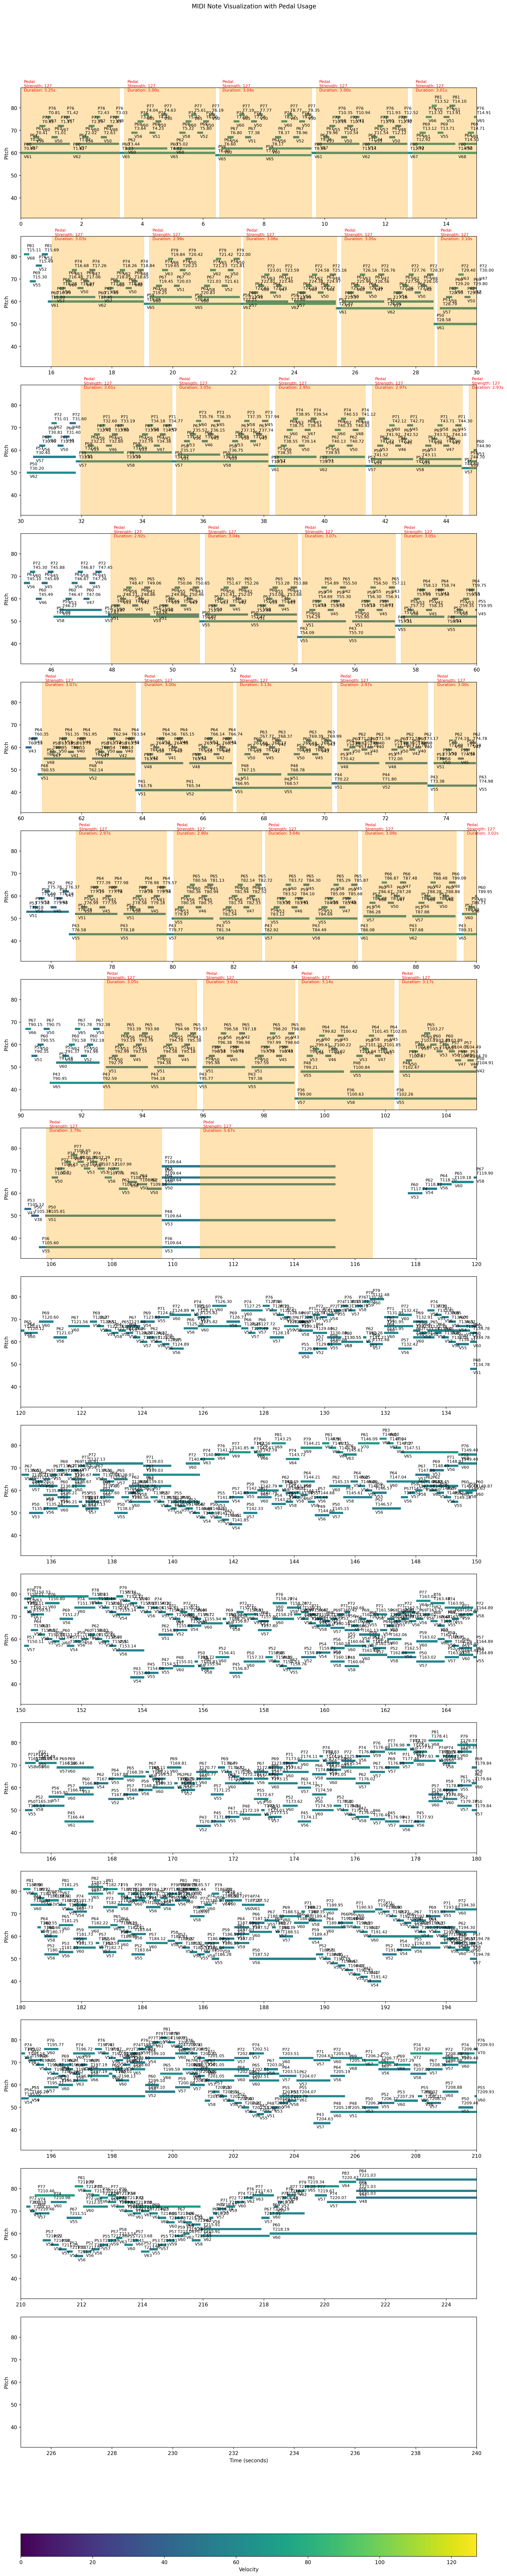

說明及單位：

1. Pitch (音高)：顯示為 MIDI 數字和音符名稱，範圍通常為 0 到 127。
2. Velocity (力度)：範圍從 0 到 127，表示音符按下的強度，通常越大表示越強。
3. Duration (持續時間)：以四分音符為單位，表示音符持續的時長。
4. Onset Time (開始時間)：以四分音符為單位，表示音符在什麼時候開始演奏。
5. Legato/Staccato：是否連續，Legato 表示音符之間連續，Staccato 表示音符之間分離。
6. Pedal Usage (踏板使用)：延音踏板的使用狀況。
7. Tempo (速度)：曲目的速度，單位為 microseconds per beat。



In [22]:
def midi_analysis_no_sheet(midi_path):
    #midi_to_audio(midi_path)
    check_control_changes(midi_path)
    #show_sheet(midi_path)
    midi_visualize(midi_path, time_per_row=15)
    midi_df(midi_path)
    



midi_analysis_no_sheet("bach_846.mid")

/Users/justinshih/opt/anaconda3/envs/new_env/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


控制變更: 重置控制器, 值: 0, 時間: 0.0
控制變更: RPN (註冊參數) LSB, 值: 0, 時間: 0.0
控制變更: RPN (註冊參數) MSB, 值: 0, 時間: 0.0
控制變更: 數據條值, 值: 12, 時間: 0.0
控制變更: RPN (註冊參數) LSB, 值: 127, 時間: 0.0
控制變更: RPN (註冊參數) MSB, 值: 127, 時間: 0.0
控制變更: 音量, 值: 100, 時間: 0.0
控制變更: 聲像, 值: 64, 時間: 0.0
控制變更: 混響效果級別, 值: 30, 時間: 0.0
控制變更: 合唱效果級別, 值: 30, 時間: 0.0


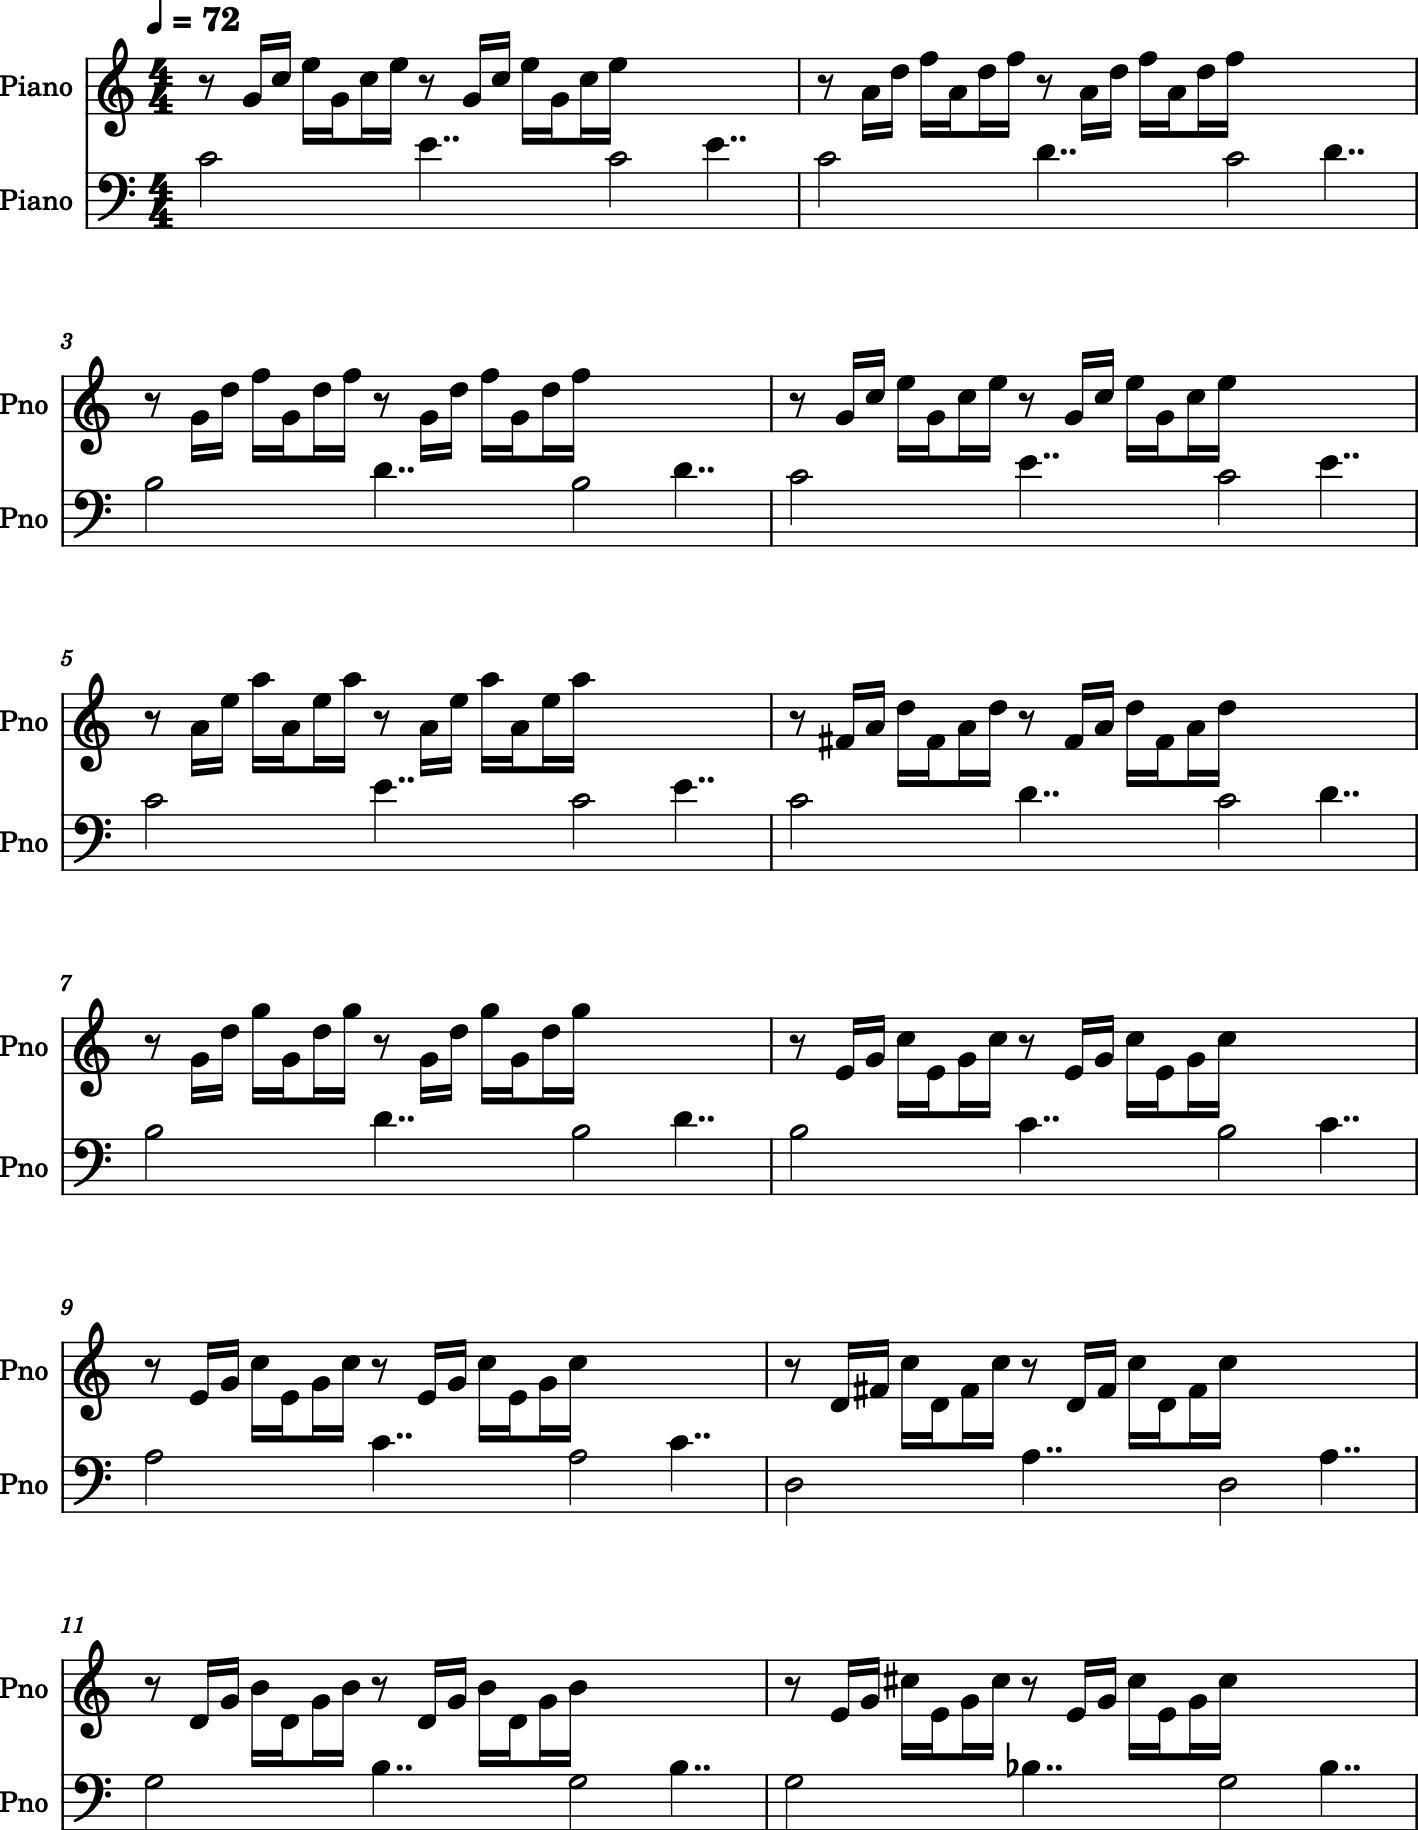

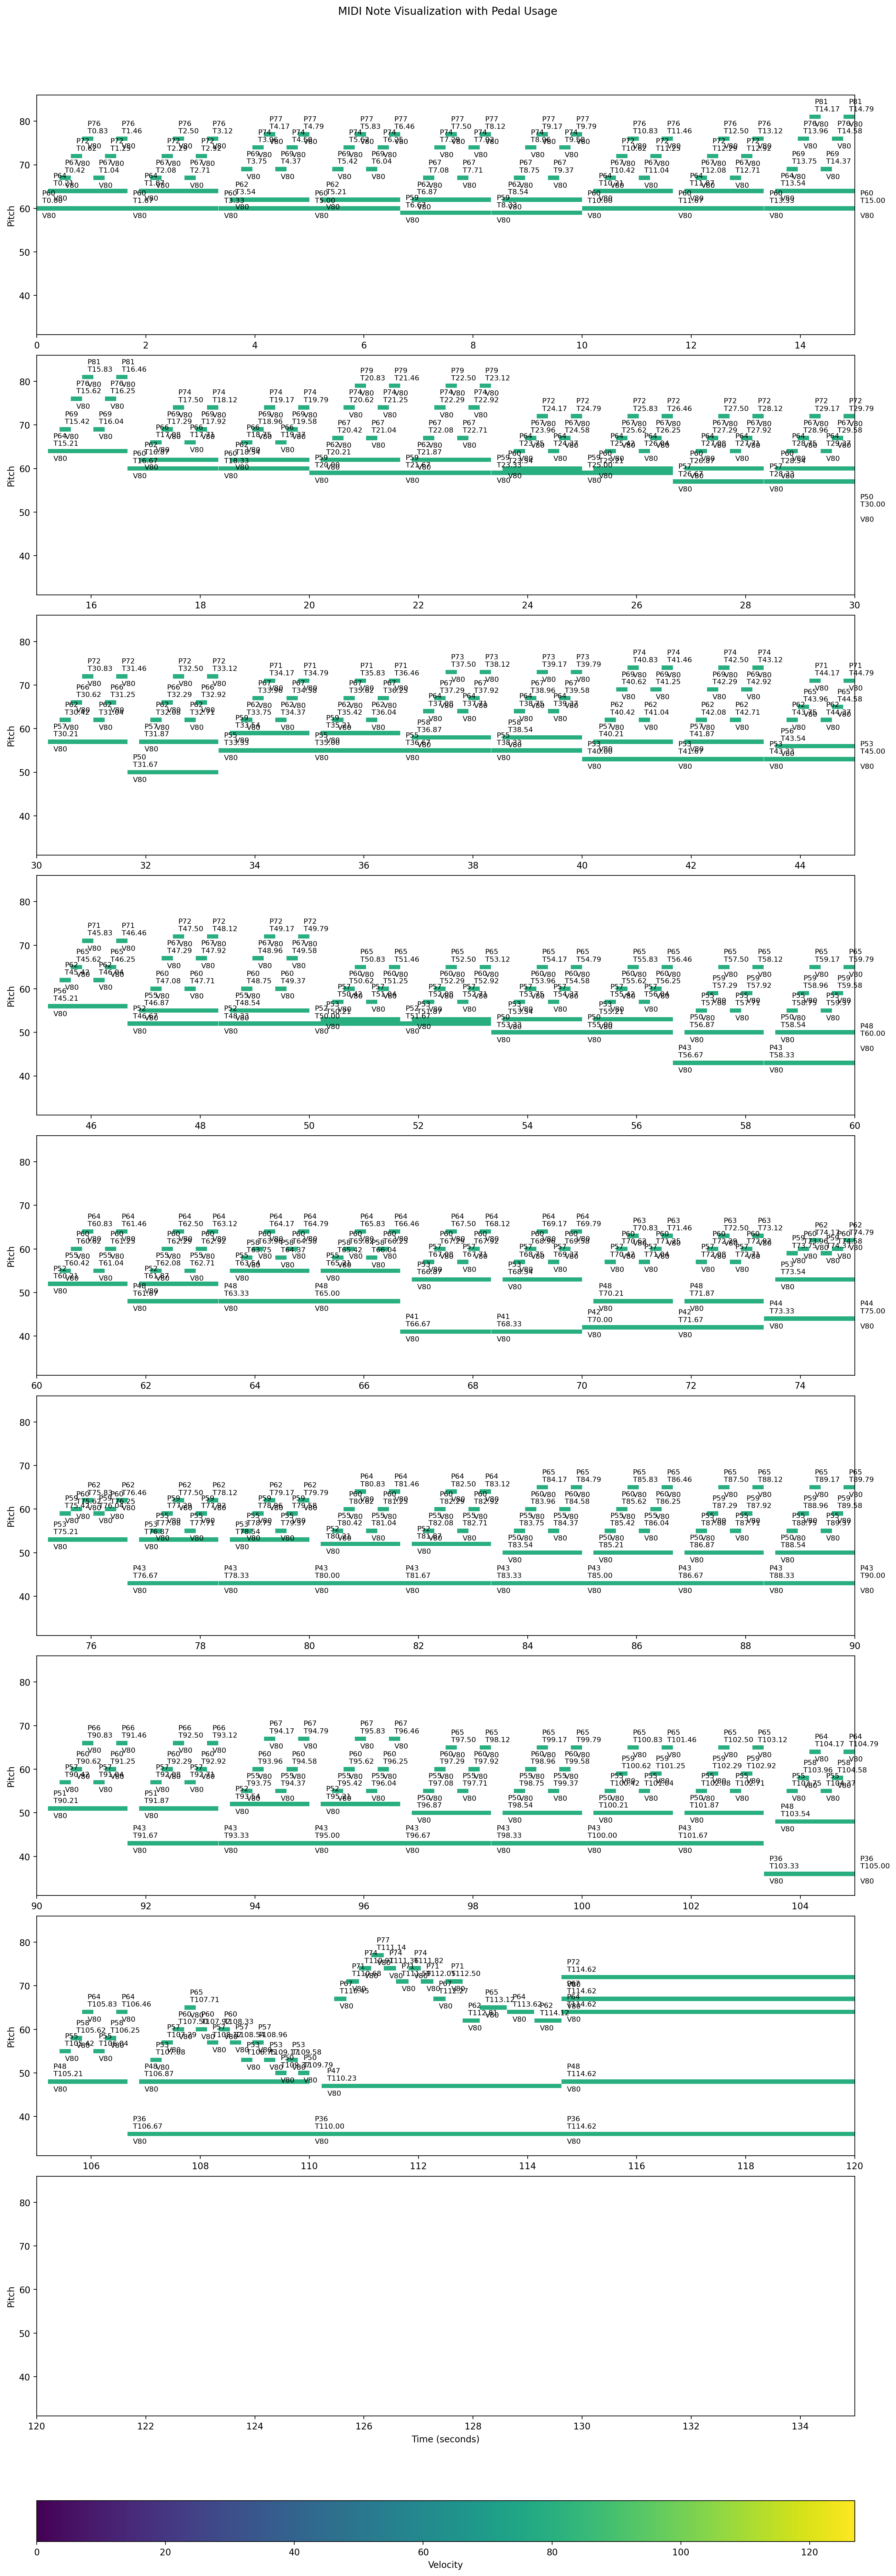

In [13]:
midi_analysis("bach_846_computer.mid")

In [4]:
def main():
    show_sheet()
    midi_visualize()
    midi_df()
    midi_analysis()
    check_control_changes()
    midi_analysis_no_sheet()

if __name__ == "__main__":
    main()


NameError: name 'show_sheet' is not defined

2024-09-24 12:35:17.824 mscore[46016:12804871] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


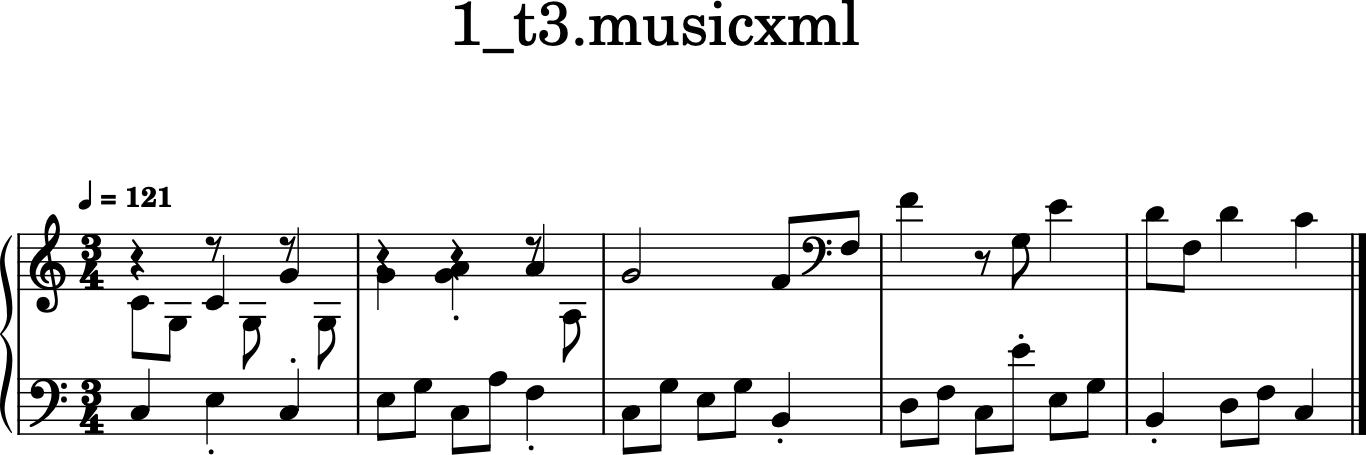

In [4]:
show_sheet("1_t3.mid")